In [1]:
%matplotlib inline

import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("./paper.mplstyle")

In [2]:
levels = ["preCp", "FirstCp", "FirstWPC", "Interim", "SecondCp", "SecondWPC", "PostCp"]
levels_diffs = [levels[i] + "_vs_" + levels[i-1] for i in range(1, len(levels))]
levels_diffs

['FirstCp_vs_preCp',
 'FirstWPC_vs_FirstCp',
 'Interim_vs_FirstWPC',
 'SecondCp_vs_Interim',
 'SecondWPC_vs_SecondCp',
 'PostCp_vs_SecondWPC']

In [3]:
beta_var = xr.open_dataset("../results/relman_abx/beta_var.nc")
beta_var = beta_var.stack(sample=["chain", "draw"])
beta_var["covariate"] = levels_diffs

In [4]:
features = beta_var["feature"]

In [5]:
firstcp_var = (
    beta_var
    .sel({"covariate": "FirstCp_vs_preCp"})
    .drop_vars("covariate")
)
num_samples = len(firstcp_var["sample"])
num_samples

2000

In [6]:
firstcp_var = (
    firstcp_var
    .assign(gt_0=firstcp_var.groupby("feature").apply(lambda x: (x > 0).sum() / num_samples).to_array())
    .assign(lt_0=firstcp_var.groupby("feature").apply(lambda x: (x < 0).sum() / num_samples).to_array())
    .assign(bounds=firstcp_var.groupby("feature").apply(lambda x: x["beta_var"].quantile([0.025, 0.975])))
    .assign(mean=firstcp_var.groupby("feature").apply(lambda x: x["beta_var"].mean()))
    .squeeze()
    .sortby("mean")
)

In [7]:
firstcp_var

<xarray.Dataset>
Dimensions:   (feature: 822, sample: 2000, quantile: 2)
Coordinates:
  * feature   (feature) object 'F4449236' 'F131559' ... 'F184318' 'F327887'
  * sample    (sample) MultiIndex
  - chain     (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  - draw      (sample) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
    variable  <U8 'beta_var'
  * quantile  (quantile) float64 0.025 0.975
Data variables:
    beta_var  (feature, sample) float64 -1.704 -3.452 -4.032 ... 0.9232 11.42
    gt_0      (feature) float64 0.02 0.01 0.0315 0.0355 ... 0.9435 0.9805 0.9855
    lt_0      (feature) float64 0.98 0.99 0.9685 0.9645 ... 0.0565 0.0195 0.0145
    bounds    (feature, quantile) float64 -15.94 -0.2916 -15.98 ... 0.6251 16.16
    mean      (feature) float64 -7.401 -7.19 -6.38 -6.325 ... 4.437 7.028 7.087

In [14]:
def smaller_p(x):
    return min(x["gt_0"], x["lt_0"])

firstcp_var_pvals = (
    firstcp_var[["gt_0", "lt_0"]]
    .drop_vars("variable")
    .to_dataframe()
)
firstcp_var_pvals["p"] = 2*firstcp_var_pvals.min(axis=1)
firstcp_var_pvals["x"] = np.arange(len(features))

firstcp_var_pvals

,gt_0,lt_0,p,x
feature,,,,
F4449236,0.0200,0.9800,0.040,0
F131559,0.0100,0.9900,0.020,1
F4301298,0.0315,0.9685,0.063,2
F4368216,0.0355,0.9645,0.071,3
F207994,0.0240,0.9760,0.048,4
...,...,...,...,...
F183849,0.9330,0.0670,0.134,817
F197442,0.9500,0.0500,0.100,818
F188348,0.9435,0.0565,0.113,819


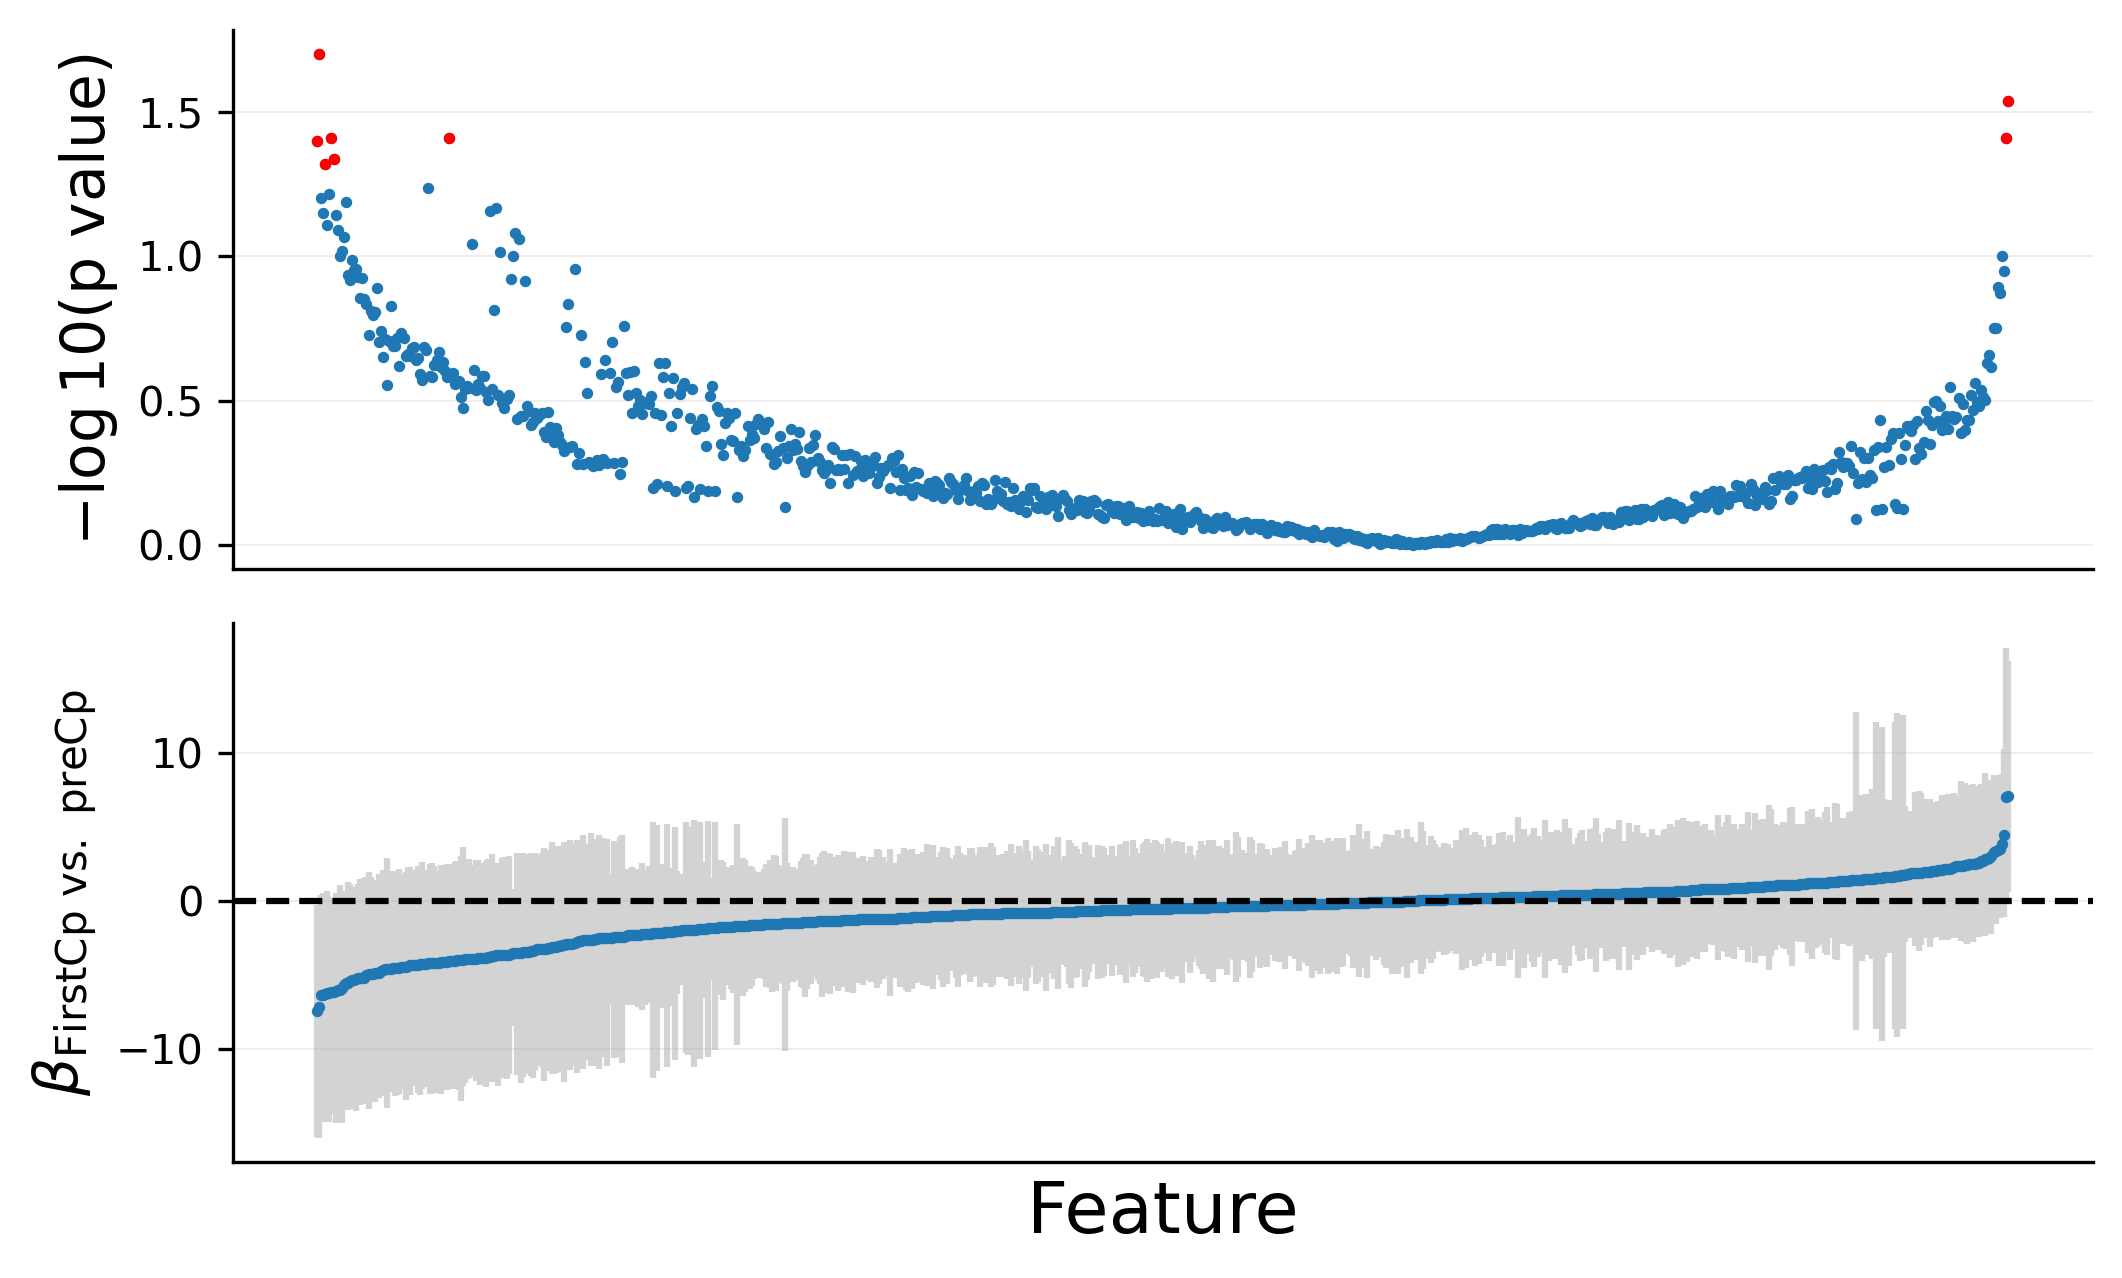

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
plt.subplots_adjust(hspace=0.1)

x = np.arange(len(features))

axs[0].scatter(
    x=x,
    y=firstcp_var_pvals["p"].apply(lambda x: -np.log10(x)),
    s=3
)
axs[0].scatter(
    x=firstcp_var_pvals.query("p < 0.05")["x"],
    y=firstcp_var_pvals.query("p < 0.05")["p"].apply(lambda x: -np.log10(x)),
    color="red",
    s=3
)

axs[1].scatter(
    x=x,
    y=firstcp_var["mean"],
    s=3
)
axs[1].errorbar(
    x=x,
    y=firstcp_var["mean"],
    yerr=np.abs((firstcp_var["bounds"].transpose() - firstcp_var["mean"]).values),
    zorder=0,
    color="lightgray"
)
axs[1].axhline(0, color="k", ls="--")

axs[0].set_ylabel(r"$-\log10\left(\mathrm{p\ value}\right)$", fontsize="x-large")
axs[1].set_ylabel(r"$\beta_{\mathrm{FirstCp\ vs.\ preCp}}$", fontsize="x-large")
axs[1].set_xlabel("Feature", fontsize="xx-large")
axs[1].set_xticks([])

for ax in axs:
    ax.grid()

plt.show()